In [1]:
import torch
import torch.nn as nn
import torch.fft as fft
import torchaudio.transforms as transforms
from torchaudio.functional import resample
from torch.utils.data import Dataset, DataLoader

import scipy.io.wavfile as wavfile
import numpy as np

from matplotlib.pyplot import plot, show

from IPython.display import Audio

In [2]:
def wav_to_tensor(file_path, sample_rate=44100):
    # Read the MP3 file and convert it to a WAV file
    rate, data = wavfile.read(file_path)
    
    # If the audio has multiple channels, take the first channel
    if len(data.shape) > 1:
        data = data[:, 0]

    # Normalize the audio data to the range [-1, 1]
    data = data / np.max(np.abs(data), axis=0)

    # Convert the numpy array to a PyTorch tensor
    tensor_data = torch.from_numpy(data).float()

    return tensor_data, rate

def numpy_to_wav(data, file_path, sample_rate=44100):
    scaled_data = np.int16(data / np.max(np.abs(data)) * 32767)
    wavfile.write(file_path, sample_rate, scaled_data)

class SpeechDataset(Dataset):
    working_sample_rate = 16000

    def __init__(self, train=True, *, filename, compression_ratio, buffer_len, prediction_shift) -> None:
        super().__init__()
        self.shift = prediction_shift
        audio_tensor, sample_rate = wav_to_tensor(filename)
        audio_tensor = resample(audio_tensor, sample_rate, self.working_sample_rate)
        reminder = len(audio_tensor) % (compression_ratio * buffer_len)
        audio_tensor = audio_tensor[:-reminder]
        audio_tensor = audio_tensor.view(-1, buffer_len, compression_ratio)
        
        self.data = audio_tensor
        self.buffer_len = buffer_len
        self.compression_ratio = compression_ratio

    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, index) -> any:
        # inputs and outputs
        inputs = self.data[index][self.shift:]
        outputs = self.data[index][:-self.shift]

        # reduce amplitude by 0.5-1.0 factor
        inputs = inputs * (0.5 + 0.5 * torch.rand((1)))

        # add noise with random amplitude 
        # inputs = inputs + 0.1 * torch.rand((1)) * torch.rand(inputs.shape)

        return inputs, outputs

    def get_combined(self, t0, dt):
        return self.data[
            (t0 * self.working_sample_rate) // self.compression_ratio // self.buffer_len
            :((t0+dt) * self.working_sample_rate) // self.compression_ratio // self.buffer_len
        ]


In [3]:
class Encoder(nn.Module):
    def __init__(self, compress_ratio=8, hidden_size=256, transfer_bit_depth=4, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.activation = nn.Tanh()
        self.linear1 = nn.Linear(compress_ratio, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.bit_depth = transfer_bit_depth

    def reduce_bit_depth(self, input_tensor, bit_depth):
        max_value = 2**bit_depth - 1
        input_tensor = input_tensor * max_value
        input_tensor = input_tensor + input_tensor.round().detach() - input_tensor.detach()
        
        normalized_tensor = input_tensor / (max_value + 1)
        
        return normalized_tensor

    def encode(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        x = self.reduce_bit_depth(x, self.bit_depth)
        return x
    
class Decoder(nn.Module):
    def __init__(self, *args, memory_size=128, compress_ratio=8, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.activation = nn.Tanh()
        self.linear1 = nn.Linear(1, compress_ratio)
        self.rnn = nn.RNN(input_size=compress_ratio, hidden_size=memory_size, num_layers=1, batch_first=True)
        self.linear2 = nn.Linear(memory_size, compress_ratio)

    def decode(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x, _ = self.rnn(x)
        x = self.linear2(x)
        x = self.activation(x)
        return x

class RecurrentAutoencoder(nn.Module):
    def __init__(self, *args, compress_ratio, transfer_bit_depth, noise_level, memory_size, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = Encoder(compress_ratio=compress_ratio, transfer_bit_depth=transfer_bit_depth)
        self.decoder = Decoder(compress_ratio=compress_ratio, memory_size=memory_size)
        self.noise_level = noise_level
     
    def forward(self, x):
        compressed = self.encoder.encode(x)
        compressed = compressed + self.noise_level * torch.randn(compressed.shape)
        decompressed = self.decoder.decode(compressed)
        return decompressed
    
    def forward_clean(self, x):
        compressed = self.encoder.encode(x)
        decompressed = self.decoder.decode(compressed)
        return decompressed

class AmplitudeSpectrumLoss(nn.Module):
    def __init__(self, window_fn=torch.hann_window):
        super(AmplitudeSpectrumLoss, self).__init__()
        self.window_fn = window_fn

    def forward(self, input_signals, target_signals):
        # Apply window function to input and target signals
        window = self.window_fn(len(input_signals[0]))  # Assuming all signals in the batch have the same length
        # input_signals = input_signals * window
        # target_signals = target_signals * window

        # Compute the amplitude spectrum using the Fourier transform
        input_spectra = fft.fft(input_signals, dim=-1, norm='forward')
        input_spectra = torch.abs(input_spectra)
        input_spectra = torch.log10(input_spectra + 1e-7)

        target_spectra = fft.fft(target_signals, dim=-1, norm='forward')
        target_spectra = torch.abs(target_spectra)
        target_spectra = torch.log10(target_spectra + 1e-7) 

        # plot(input_spectra[0].detach().numpy())
        # plot(target_spectra[0].detach().numpy())
        # show()

        # Calculate the mean squared error between the amplitude spectra
        loss = nn.MSELoss()(input_spectra, target_spectra)

        return loss

class MelSpectrogramLoss(nn.Module):
    def __init__(self, sample_rate=16000):
        super(MelSpectrogramLoss, self).__init__()
        self.mel_transform = transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_mels=32
        )
        self.mse_loss = nn.MSELoss()

    def forward(self, predicted_audio, target_audio):
        # Calculate mel spectrograms
        predicted_mel = self.mel_transform(predicted_audio)
        target_mel = self.mel_transform(target_audio)
        # Compute MSE loss between mel spectrograms
        loss = self.mse_loss(predicted_mel, target_mel)

        return loss



In [4]:
train_dataset = SpeechDataset(filename='dataset/Tadek_7_2min.wav', compression_ratio=3, buffer_len=2048, prediction_shift=1)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)

eval_dataset = SpeechDataset(filename='dataset/lalka_train.wav', compression_ratio=3, buffer_len=2048, prediction_shift=1)

eval_loader = DataLoader(
    dataset=eval_dataset,
    batch_size=32,
    shuffle=True
)

test_dataset = SpeechDataset(filename='dataset/lalka_test.wav', compression_ratio=3, buffer_len=2048, prediction_shift=1)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=True
)

/var/folders/ws/lcbm98wj3nd9b9prdg8_tv800000gn/T/ipykernel_95541/1821072689.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wavfile.read(file_path)


In [5]:
model = RecurrentAutoencoder(compress_ratio=3, transfer_bit_depth=4, noise_level=0.0, memory_size=64)
best_loss = float('inf')

Y_MSE = []
Y_MEL = []
Y_VAL = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Function to train the model for one epoch.

    Args:
    - model: PyTorch model to be trained
    - dataloader: PyTorch DataLoader for loading training data
    - criterion: Loss function (e.g., nn.CrossEntropyLoss())
    - optimizer: Optimizer (e.g., SGD, Adam)
    - device: Device to perform computations (e.g., 'cuda' if using GPU)

    Returns:
    - epoch_loss: Total loss for the epoch
    - epoch_accuracy: Accuracy for the epoch
    """

    # Set model to training mode
    model.train()

    epoch_loss = 0.0

    # Iterate over the dataloader
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        batch_n = len(inputs)
        loss = criterion(outputs.view(batch_n, -1), labels.view(batch_n, -1))
        epoch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate epoch loss and accuracy
    epoch_loss /= len(dataloader)

    return epoch_loss

def eval_epoch(model, dataloader, criterion, device):
    """
    Function to train the model for one epoch.

    Args:
    - model: PyTorch model to be trained
    - dataloader: PyTorch DataLoader for loading training data
    - criterion: Loss function (e.g., nn.CrossEntropyLoss())
    - device: Device to perform computations (e.g., 'cuda' if using GPU)

    Returns:
    - epoch_loss: Total loss for the epoch
    """

    # Set model to training mode
    model.eval()

    epoch_loss = 0.0

    # Iterate over the dataloader
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        batch_n = len(inputs)
        loss = criterion(outputs.view(batch_n, -1), labels.view(batch_n, -1))
        epoch_loss += loss.item()


    # Calculate epoch loss and accuracy
    epoch_loss /= len(dataloader)

    return epoch_loss



Epoch: 0, train loss: 0.012237665243446827, val loss: 0.9032357566886478 [best_loss, model saved]
Epoch: 1, train loss: 0.011480053463442759, val loss: 0.8430353237522973 [best_loss, model saved]
Epoch: 2, train loss: 0.011575742794031446, val loss: 0.9037281374136606
Epoch: 3, train loss: 0.011146845804019407, val loss: 0.834270692533917 [best_loss, model saved]
Epoch: 4, train loss: 0.01106269225816835, val loss: 0.7734120223257277 [best_loss, model saved]
Epoch: 5, train loss: 0.0103708161464469, val loss: 0.6977200839254591 [best_loss, model saved]
Epoch: 6, train loss: 0.009080594913526014, val loss: 0.6368216276168823 [best_loss, model saved]
Epoch: 7, train loss: 0.006717635233971206, val loss: 0.6283264557520548 [best_loss, model saved]


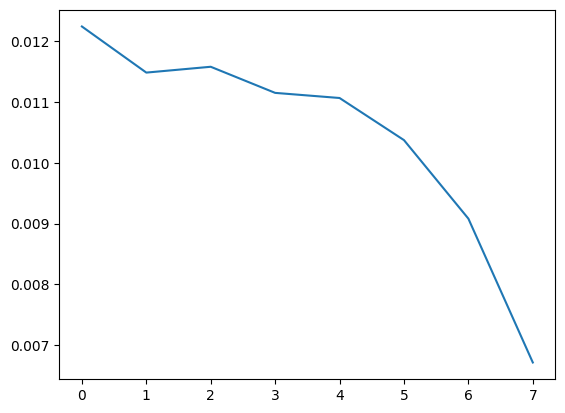

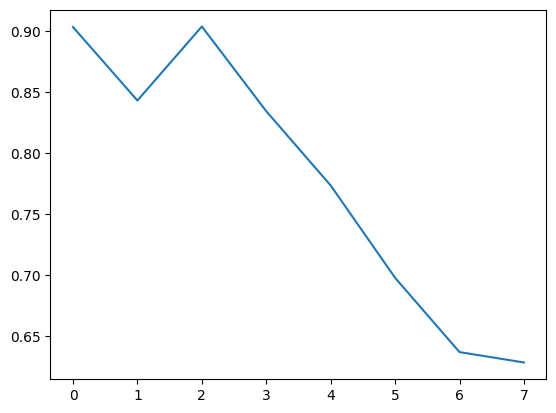

In [7]:
for epoch in range(8):
    epoch_loss = train_epoch(model, train_loader, nn.MSELoss(), optimizer, torch.device('cpu'))
    val_loss = eval_epoch(model, eval_loader, AmplitudeSpectrumLoss(), torch.device('cpu'))

    Y_MSE.append(epoch_loss)
    Y_VAL.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        print(f'Epoch: {epoch}, train loss: {epoch_loss}, val loss: {val_loss} [best_loss, model saved]')
        torch.save(model, 'model.pt')

    else:
        print(f'Epoch: {epoch}, train loss: {epoch_loss}, val loss: {val_loss}')


plot(Y_MSE)
show()
plot(Y_VAL)
show()

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch: 0, train loss: 0.9476071487773549, val loss: 0.5291411860121621 [best_loss, model saved]
Epoch: 1, train loss: 0.8734979439865459, val loss: 0.5764452252123091
Epoch: 2, train loss: 0.7204243242740631, val loss: 0.46526921292146045 [best_loss, model saved]
Epoch: 3, train loss: 0.6206799014048143, val loss: 0.4460919267601437 [best_loss, model saved]
Epoch: 4, train loss: 0.568705675276843, val loss: 0.3822486913866467 [best_loss, model saved]
Epoch: 5, train loss: 0.43484487587755377, val loss: 0.3553512609667248 [best_loss, model saved]
Epoch: 6, train loss: 0.3930608792738481, val loss: 0.34497593177689445 [best_loss, model saved]
Epoch: 7, train loss: 0.3852451199834997, val loss: 0.3670862714449565
Epoch: 8, train loss: 0.409641986543482, val loss: 0.37578410738044316
Epoch: 9, train loss: 0.4232599681073969, val loss: 0.5167311976353327
Epoch: 10, train loss: 0.3376476900144057, val loss: 0.34564415448241764
Epoch: 11, train loss: 0.33852886340834876, val loss: 0.346716268

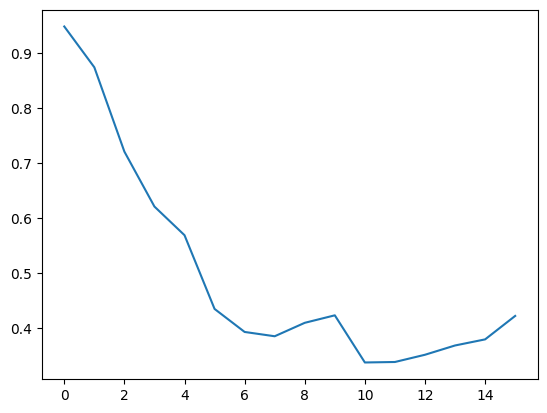

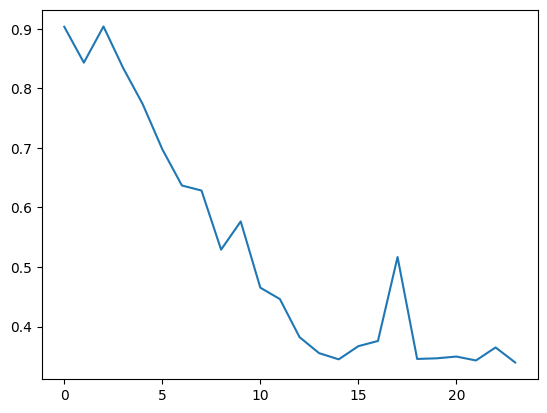

In [9]:
for epoch in range(16):
    epoch_loss = train_epoch(model, train_loader, AmplitudeSpectrumLoss(), optimizer, torch.device('cpu'))
    val_loss = eval_epoch(model, eval_loader, AmplitudeSpectrumLoss(), torch.device('cpu'))

    Y_MEL.append(epoch_loss)
    Y_VAL.append(val_loss)
    
    if val_loss < best_loss:
        best_loss = val_loss
        print(f'Epoch: {epoch}, train loss: {epoch_loss}, val loss: {val_loss} [best_loss, model saved]')
        torch.save(model, 'model.pt')

    else:
        print(f'Epoch: {epoch}, train loss: {epoch_loss}, val loss: {val_loss}')

plot(Y_MEL)
show()
plot(Y_VAL)
show()

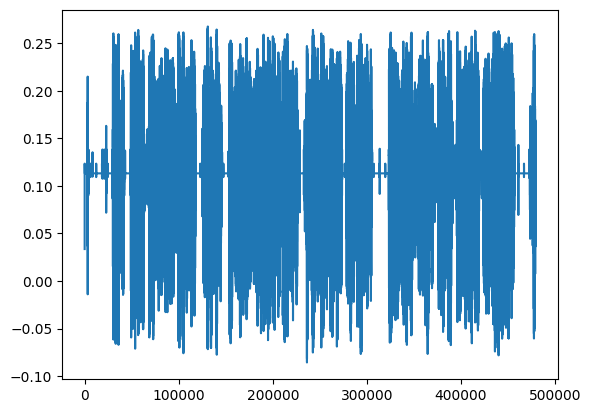

In [11]:
test_model = torch.load('model.pt')
test_model.eval()
audio_input = test_dataset.get_combined(0, 30)
output = test_model.forward(audio_input).view(-1).detach().numpy()
output = np.convolve(output, np.ones((3)) / 3)
numpy_to_wav(output, 'rnn_output.wav', sample_rate=16000)

plot(output)
show()

Audio('rnn_output.wav')